# 0. Setting

In [0]:
# Efficient Net은 nigthly에 있음, 코랩에서 재설치 필요
!pip install --upgrade tf-nightly-gpu

     |████████████████████████████████| 350.2MB 52kB/s 
     |████████████████████████████████| 460kB 40.8MB/s 
     |████████████████████████████████| 3.0MB 38.4MB/s 


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import cv2

In [0]:
cd '/content/drive/My Drive/Projects/full_bodyshot_classification/src/model'

/content/drive/My Drive/Projects/full_bodyshot_classification/src/model


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import *

train_dir = 'data/train'
validation_dir = 'data/valid'
test_dir = 'data/test'



train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=90,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=64,
        shuffle = True,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=64,
        shuffle = True,
        class_mode='binary')

Found 10374 images belonging to 2 classes.
Found 1154 images belonging to 2 classes.


# 1. Modeling

In [0]:
import tensorflow as tf
from tensorflow.keras.applications import *

In [0]:
efficient = EfficientNetB0(weights='imagenet',include_top=False,pooling='max')

16711680/16705208 [==============================] - 0s 0us/step


In [0]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.kears.callbacks import *
model = Sequential()
model.add(efficient)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               327936    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 4,377,764
Trainable params: 4,335,741
Non-trainable params: 42,023
_________________________________________________________________


In [0]:
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['acc'])

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=20,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
20/20 [==============================] - 982s 49s/step - loss: 2.8493 - acc: 0.5680 - val_loss: 0.7073 - val_acc: 0.4875
Epoch 2/30
20/20 [==============================] - 688s 34s/step - loss: 0.5588 - acc: 0.7133 - val_loss: 0.7305 - val_acc: 0.5125
Epoch 3/30
20/20 [==============================] - 505s 25s/step - loss: 0.4886 - acc: 0.7602 - val_loss: 1.0778 - val_acc: 0.4969
Epoch 4/30
 6/20 [========>.....................] - ETA: 4:23 - loss: 0.4728 - acc: 0.7526

In [0]:
model.save('effinet_just30epoch.h5')

In [0]:
def generate_grad_cam(img_tensor, model, class_index, activation_layer):
    """
    params:
    -------
    img_tensor: resnet50 모델의 이미지 전처리를 통한 image tensor
    model: pretrained resnet50 모델 (include_top=True)
    class_index: 이미지넷 정답 레이블
    activation_layer: 시각화하려는 레이어 이름

    return:
    grad_cam: grad_cam 히트맵
    """
    inp = model.input
    y_c = model.output.op.inputs[0][0, class_index]
    A_k = model.get_layer(activation_layer).output
    
    ## 이미지 텐서를 입력해서
    ## 해당 액티베이션 레이어의 아웃풋(a_k)과
    ## 소프트맥스 함수 인풋의 a_k에 대한 gradient를 구한다.
    get_output = K.function([inp], [A_k, K.gradients(y_c, A_k)[0], model.output])
    [conv_output, grad_val, model_output] = get_output([img_tensor])

    ## 배치 사이즈가 1이므로 배치 차원을 없앤다.
    conv_output = conv_output[0]
    grad_val = grad_val[0]
    
    ## 구한 gradient를 픽셀 가로세로로 평균내서 a^c_k를 구한다.
    weights = np.mean(grad_val, axis=(0, 1))
    
    ## 추출한 conv_output에 weight를 곱하고 합하여 grad_cam을 얻는다.
    grad_cam = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        grad_cam += w * conv_output[:, :, k]
    
    grad_cam = cv2.resize(grad_cam, (224, 224))

    ## ReLU를 씌워 음수를 0으로 만든다.
    grad_cam = np.maximum(grad_cam, 0)

    grad_cam = grad_cam / grad_cam.max()
    return grad_cam

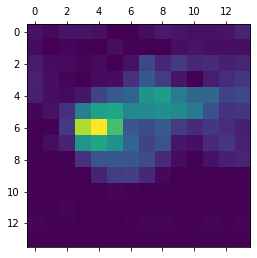

In [0]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [0]:
import cv2
img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = heatmap * 0.4 + img

cv2.imwrite('elephant_cam.jpg', superimposed_img)